In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import sys 
import pickle
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../../src')

In [4]:
adata = sc.read_h5ad('/Volumes/SSD/training_data/snrna_human_melanoma.h5ad')
adata

AnnData object with n_obs × n_vars = 4804 × 3396
    obs: 'X', 'Y', 'cell_type', 'author_cell_type', 'cell_type_int'
    uns: 'author_cell_type_colors', 'cell_thresholds', 'neighbors', 'pca', 'received_ligands', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count'
    obsp: 'connectivities', 'distances'

In [5]:
from spaceoracle.gene_factory import GeneFactory

gf = GeneFactory.from_json(
    adata, 
    '/Volumes/SSD/lasso_runs/human_melanoma/run_params.json', 
    override_params={
        'save_dir': '/Volumes/SSD/lasso_runs/human_melanoma'
    }
)

assert len(gf.queue.remaining_genes) == 0

In [6]:
from spaceoracle.beta import Betabase

bdb = Betabase(
    gf.adata, 
    gf.save_dir, 
    subsample=None, 
    float16=True, 
    obs_names=adata.obs_names,
    auto_load=False
)

In [7]:
from spaceoracle.plotting.cartography import xy_from_adata

In [8]:
xy = xy_from_adata(adata)

In [10]:
adata.obs['cell_type'].value_counts()

cell_type
CD8+ T      2119
Tumor 1      812
Mono-mac     692
Plasma/B     654
CD4+ T       198
Treg         123
Other        119
Tumor 2       87
Name: count, dtype: int64

In [12]:

# %%time

# interactions = {}

# for ct in ['Tumor 1', 'Treg', 'CD8+ T']:
#     interactions[ct] = bdb.collect_interactions(cell_type=ct, annot='cell_type')

In [14]:
# with open('interactions.pkl', 'wb') as f:
#     pickle.dump(interactions, f)

In [13]:
with open('interactions.pkl', 'rb') as f:
    interactions = pickle.load(f)

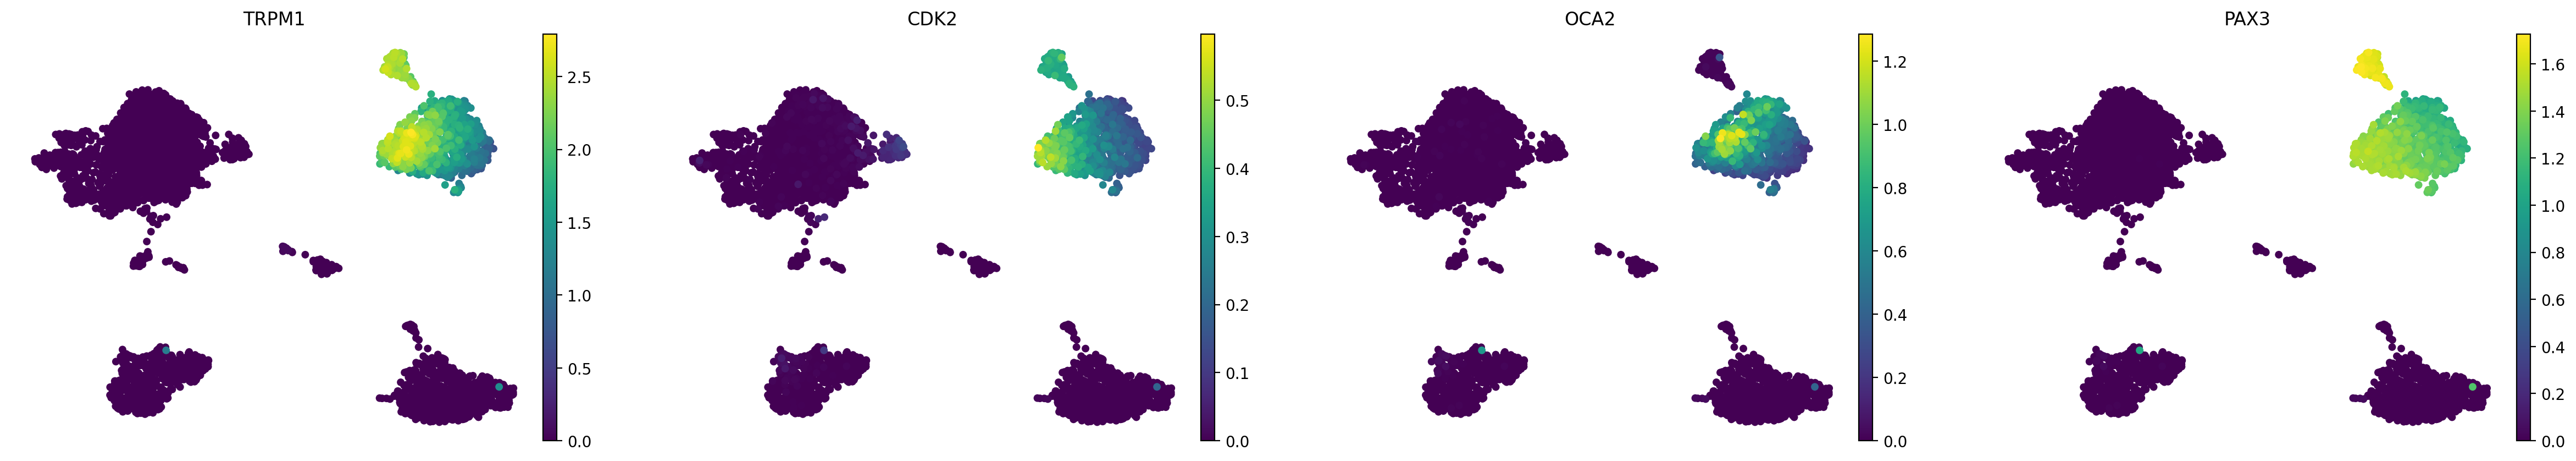

In [136]:

sc.pl.umap(adata, color=['TRPM1', 'CDK2', 'OCA2', 'PAX3'], s=100, layer='imputed_count', frameon=False)

In [146]:
dfr = interactions['Tumor 1'].query(
    'gene.str.contains("PMEL|TRPM1|CDK2|OCA2") and interaction_type=="ligand-receptor"').groupby(
    'interaction').sum().sort_values(
    by='beta', ascending=False)

# dfr = interactions['Tumor 1'].query(
#     'gene.str.contains("OCA2") and interaction_type=="ligand-receptor"').groupby(
#     'interaction').sum().sort_values(
#     by='beta', ascending=False)
    

mean_cd8_expr = adata.to_df(layer='imputed_count')[
    adata.obs.cell_type=='CD8+ T'].quantile(0.25).to_frame().loc[
        dfr.index.str.replace('beta_', '').str.split('$').str[0].values]

mean_tumor_expr = adata.to_df(layer='imputed_count')[
    adata.obs.cell_type=='Tumor 1'].quantile(0.75).to_frame().loc[
        dfr.index.str.replace('beta_', '').str.split('$').str[1].values]
    
dfr['mean_cd8_expr'] = mean_cd8_expr.values
dfr['mean_tumor_expr'] = mean_tumor_expr.values
# dfr['weighted_beta'] = dfr['beta'] * dfr['mean_cd8_expr'] * dfr['mean_tumor_expr']
# dfr['weighted_beta'] = dfr['beta'] * dfr['mean_cd8_expr']
dfr['weighted_beta'] = dfr['beta'] * dfr['mean_tumor_expr']
dfr.index = dfr.index.str.replace('beta_', '').str.replace('$', '-')
top_interactions = dfr[dfr['weighted_beta'] < 0].sort_values(by='weighted_beta', ascending=True).head(15)[::-1]

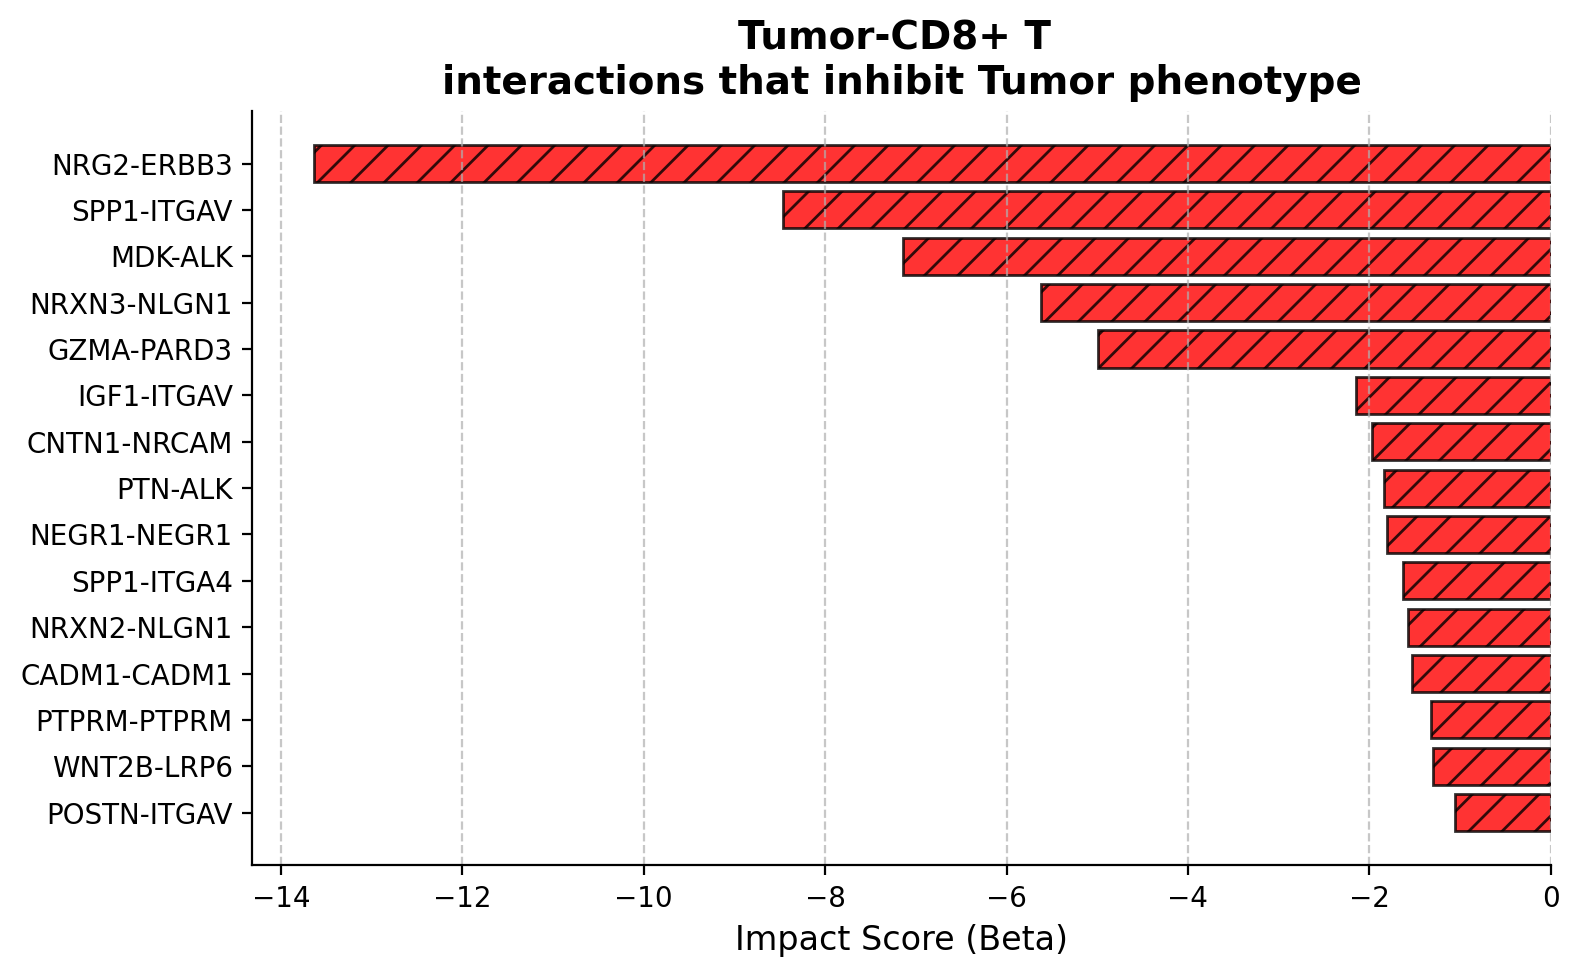

In [147]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)
bars = ax.barh(top_interactions.index, top_interactions['weighted_beta'], 
    color='red', edgecolor='black', alpha=0.8, hatch='//')
ylabels = [label.get_text() for label in ax.get_yticklabels()]

ax.set_xlabel('Impact Score (Beta)', fontsize=12)
ax.set_title('Tumor-CD8+ T \ninteractions that inhibit Tumor phenotype', fontsize=14, fontweight='bold')
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [150]:
interactions['CD8+ T'].query('interaction_type=="tf" and gene.str.contains("NRG2|SPP1|GZMA|IL26|ANGPT2|NRXN3|CNTN1")').sort_values(
    by='beta', ascending=False).head(15)

,interaction,gene,beta,interaction_type
CD8+ T,,,,
38967,beta_GRHL2,GZMA,3.753025,tf
26396,beta_HOXB4,GZMA,1.614618,tf
22893,beta_GLIS3,ANGPT2,1.268348,tf
19627,beta_ARID3A,GZMA,1.034110,tf
25256,beta_ZNF341,GZMA,1.008095,tf
32214,beta_NR2F1,SPP1,0.986790,tf
27745,beta_ARID3B,GZMA,0.833494,tf
39868,beta_RFX4,ANGPT2,0.830808,tf
43761,beta_LHX2,ANGPT2,0.822867,tf


In [151]:
interactions['CD8+ T'].query('interaction_type=="tf" and gene.str.contains("NRG2|SPP1|GZMA|IL26|ANGPT2|NRXN3|CNTN1")').sort_values(
    by='beta', ascending=True).head(15)

,interaction,gene,beta,interaction_type
CD8+ T,,,,
35532,beta_GATA1,GZMA,-1.786869,tf
37274,beta_NR4A3,ANGPT2,-1.601314,tf
34079,beta_NFIB,GZMA,-1.466811,tf
21741,beta_FOXP3,ANGPT2,-1.202151,tf
39434,beta_IRF4,GZMA,-1.072370,tf
4262,beta_PAX5,ANGPT2,-0.924547,tf
22339,beta_FOXP4,ANGPT2,-0.848990,tf
41824,beta_MYB,IL26,-0.728020,tf
17452,beta_TBX21,IL26,-0.549414,tf


In [162]:
tf_targets = interactions['CD8+ T'].query('interaction_type=="tf" and gene.str.contains("NRG2|SPP1|GZMA|IL26|ANGPT2|NRXN3|CNTN1")').sort_values(
    by='beta', ascending=True).head(19)['interaction'].str.split('beta_').str[1].values

In [166]:
tf_targets_str = '|'.join(list(tf_targets))

In [178]:
interactions['CD8+ T'].query(
    'interaction_type=="tf" and gene.str.contains(@tf_targets_str) and interaction != "beta0"').sort_values(
        by='beta', ascending=False).head(100).interaction.value_counts()

interaction
beta_PAX5       7
beta_EGR2       7
beta_MEF2C      6
beta_GLIS3      5
beta_ZNF341     5
beta_TFDP1      5
beta_EPAS1      4
beta_STAT3      4
beta_PAX8       4
beta_ID2        3
beta_NPAS3      3
beta_NFKB2      3
beta_GATA1      3
beta_EGR3       3
beta_BATF       2
beta_NR4A2      2
beta_PRDM1      2
beta_IRF8       2
beta_EBF1       2
beta_BCL6       2
beta_TFEC       2
beta_PLAGL1     2
beta_ZFP3       2
beta_XBP1       2
beta_IRF4       2
beta_TCF4       2
beta_FOXP4      1
beta_GATA3      1
beta_ESRRA      1
beta_PKNOX1     1
beta_HOXB4      1
beta_CREB3L2    1
beta_STAT1      1
beta_ZFY        1
beta_NR2F1      1
beta_PATZ1      1
beta_ARID3A     1
beta_RFX4       1
beta_NFKB1      1
beta_NR4A3      1
Name: count, dtype: int64

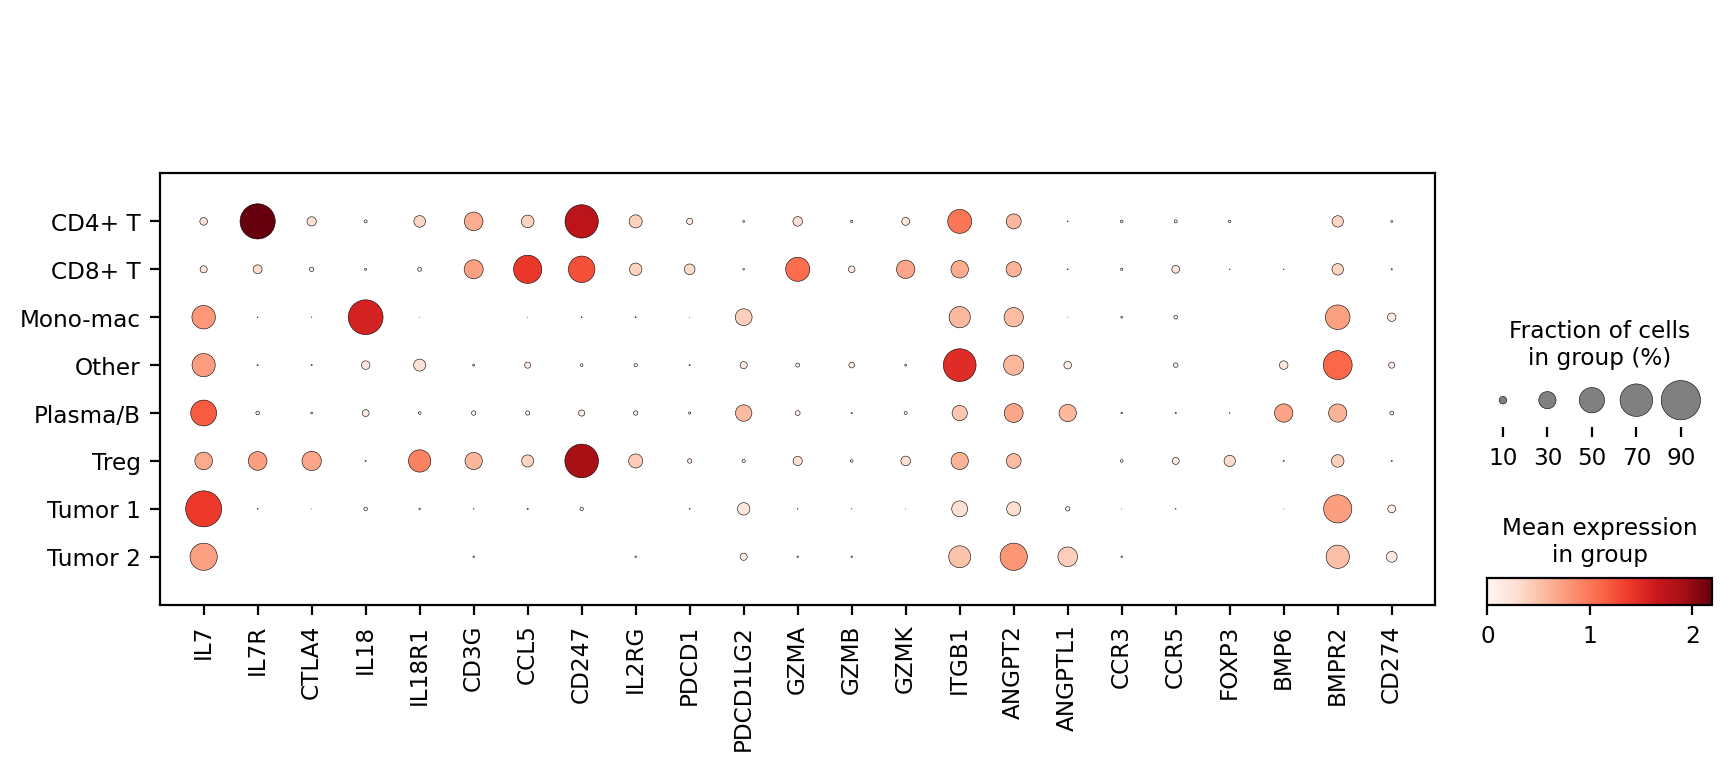

In [307]:
sc.pl.dotplot(adata, groupby='cell_type', 
    var_names=[
        'IL7', 'IL7R', 'CTLA4', 'IL18', 'IL18R1', 
        'CD3G', 'CCL5', 'CD247', 'IL2RG', 'PDCD1', 
        'PDCD1LG2', 'GZMA', 'GZMB', 'GZMK', 'ITGB1', 
        'ANGPT2', 'ANGPTL1', 'CCR3', 'CCR5', 'FOXP3', 
        'BMP6', 'BMPR2', 'CD274'])

In [91]:
'SEMA6A' in adata.var_names

True

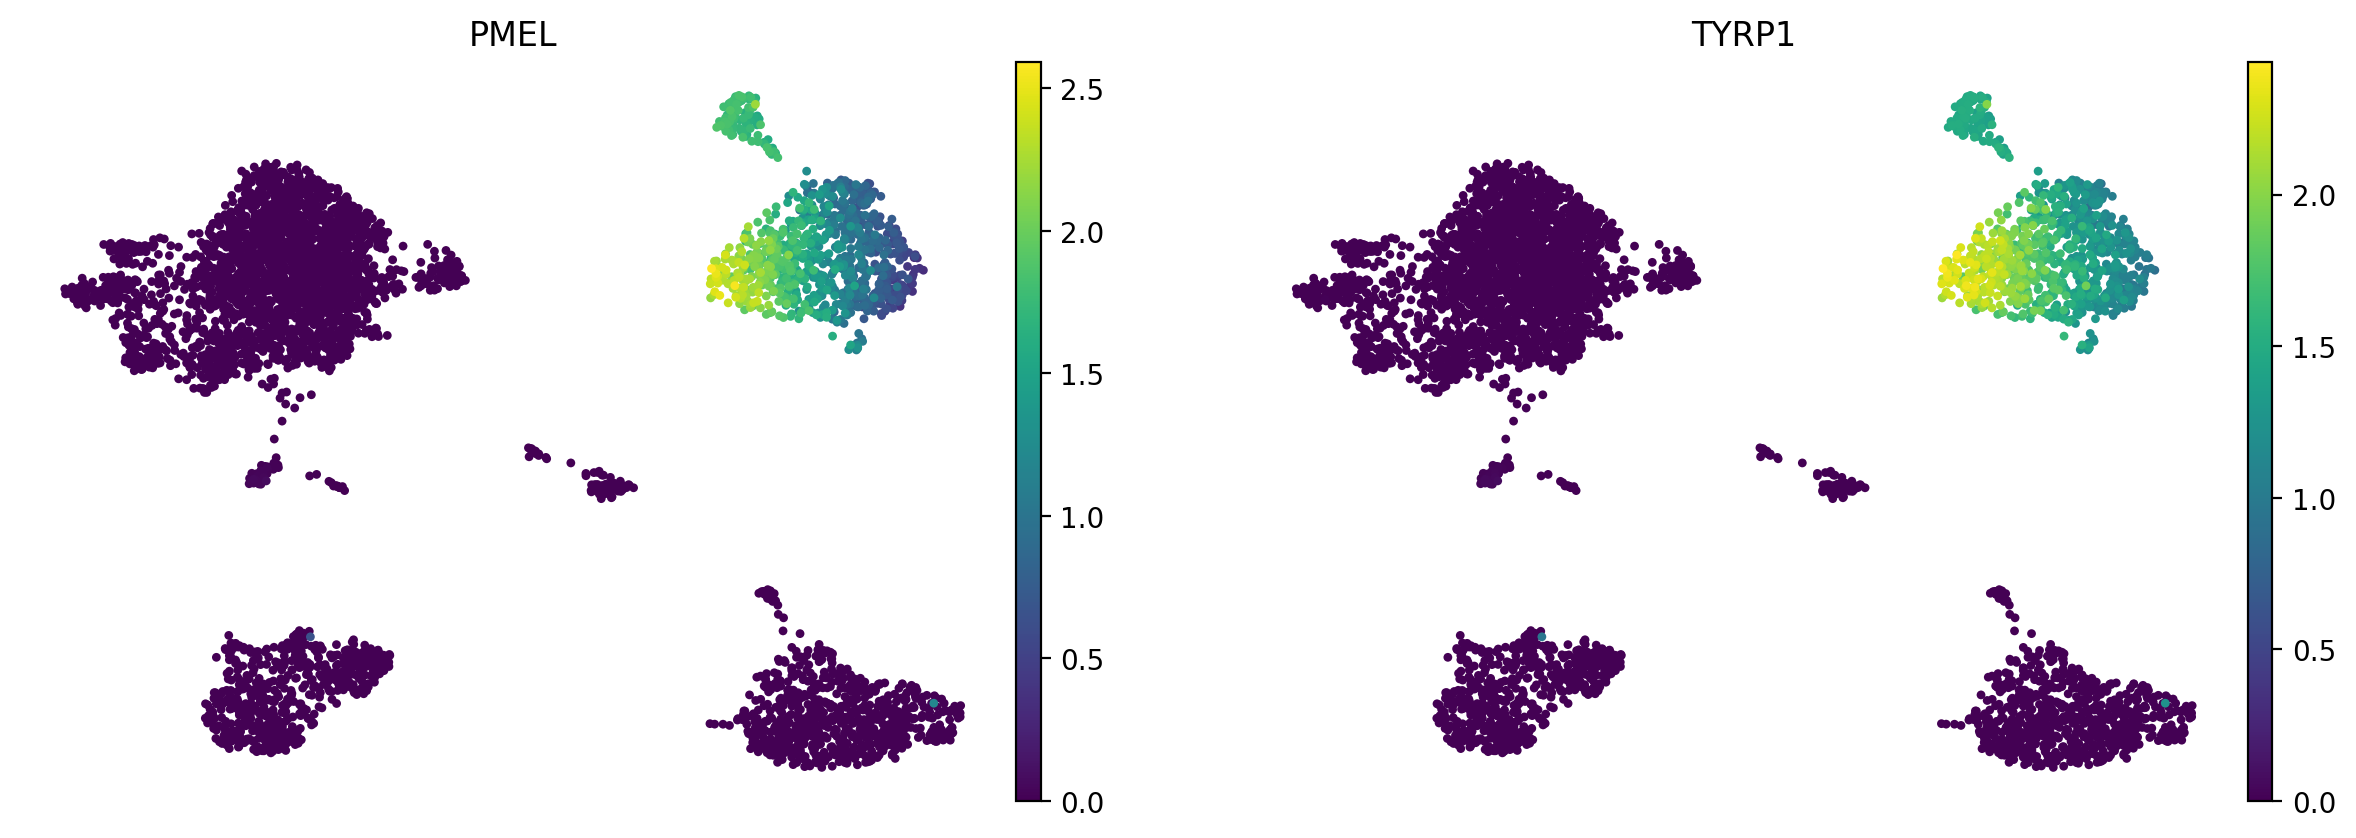

In [15]:
## https://pmc.ncbi.nlm.nih.gov/articles/PMC7851490/
# high activity of these is significantly associated with a poor prognosis
sc.pl.umap(adata, color=['PMEL', 'TYRP1'], 
    legend_loc='on data', layer='imputed_count', s=40, frameon=False)


In [17]:
from spaceoracle.virtual_tissue import VirtualTissue

In [21]:
color_dict = {
    'CD8+ T': '#ce4d3d',
    'Tumor 1': '#58a968', 
    'Mono-mac': '#b05cc6',
    'Plasma/B': '#9ea13d',
    'CD4+ T': '#6e80cc',
    'Treg': '#c1823f',
    'Other': '#cc5692',
    'Tumor 2': '#bf6776'
}

In [22]:
melanoma = VirtualTissue(
    adata = adata,
    annot = 'cell_type',
    # betadatas_path = '/Volumes/SSD/lasso_runs/human_tonsil',
    # ko_path = '/Volumes/SSD/genome_screens/human_melanoma', 
    color_dict=color_dict
)

In [23]:
melanoma.init_cartography(adata)

In [127]:
# perturbed_df = pd.read_parquet(f'/Volumes/SSD/genome_screens/melanoma_special/PATZ1_CD8T_KO.parquet')
perturbed_df = pd.read_parquet(f'/Volumes/SSD/genome_screens/melanoma_special/NRG2_CD8T_KO.parquet')

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/SSD/genome_screens/melanoma_special/NRG2_CD8T_KO.parquet'

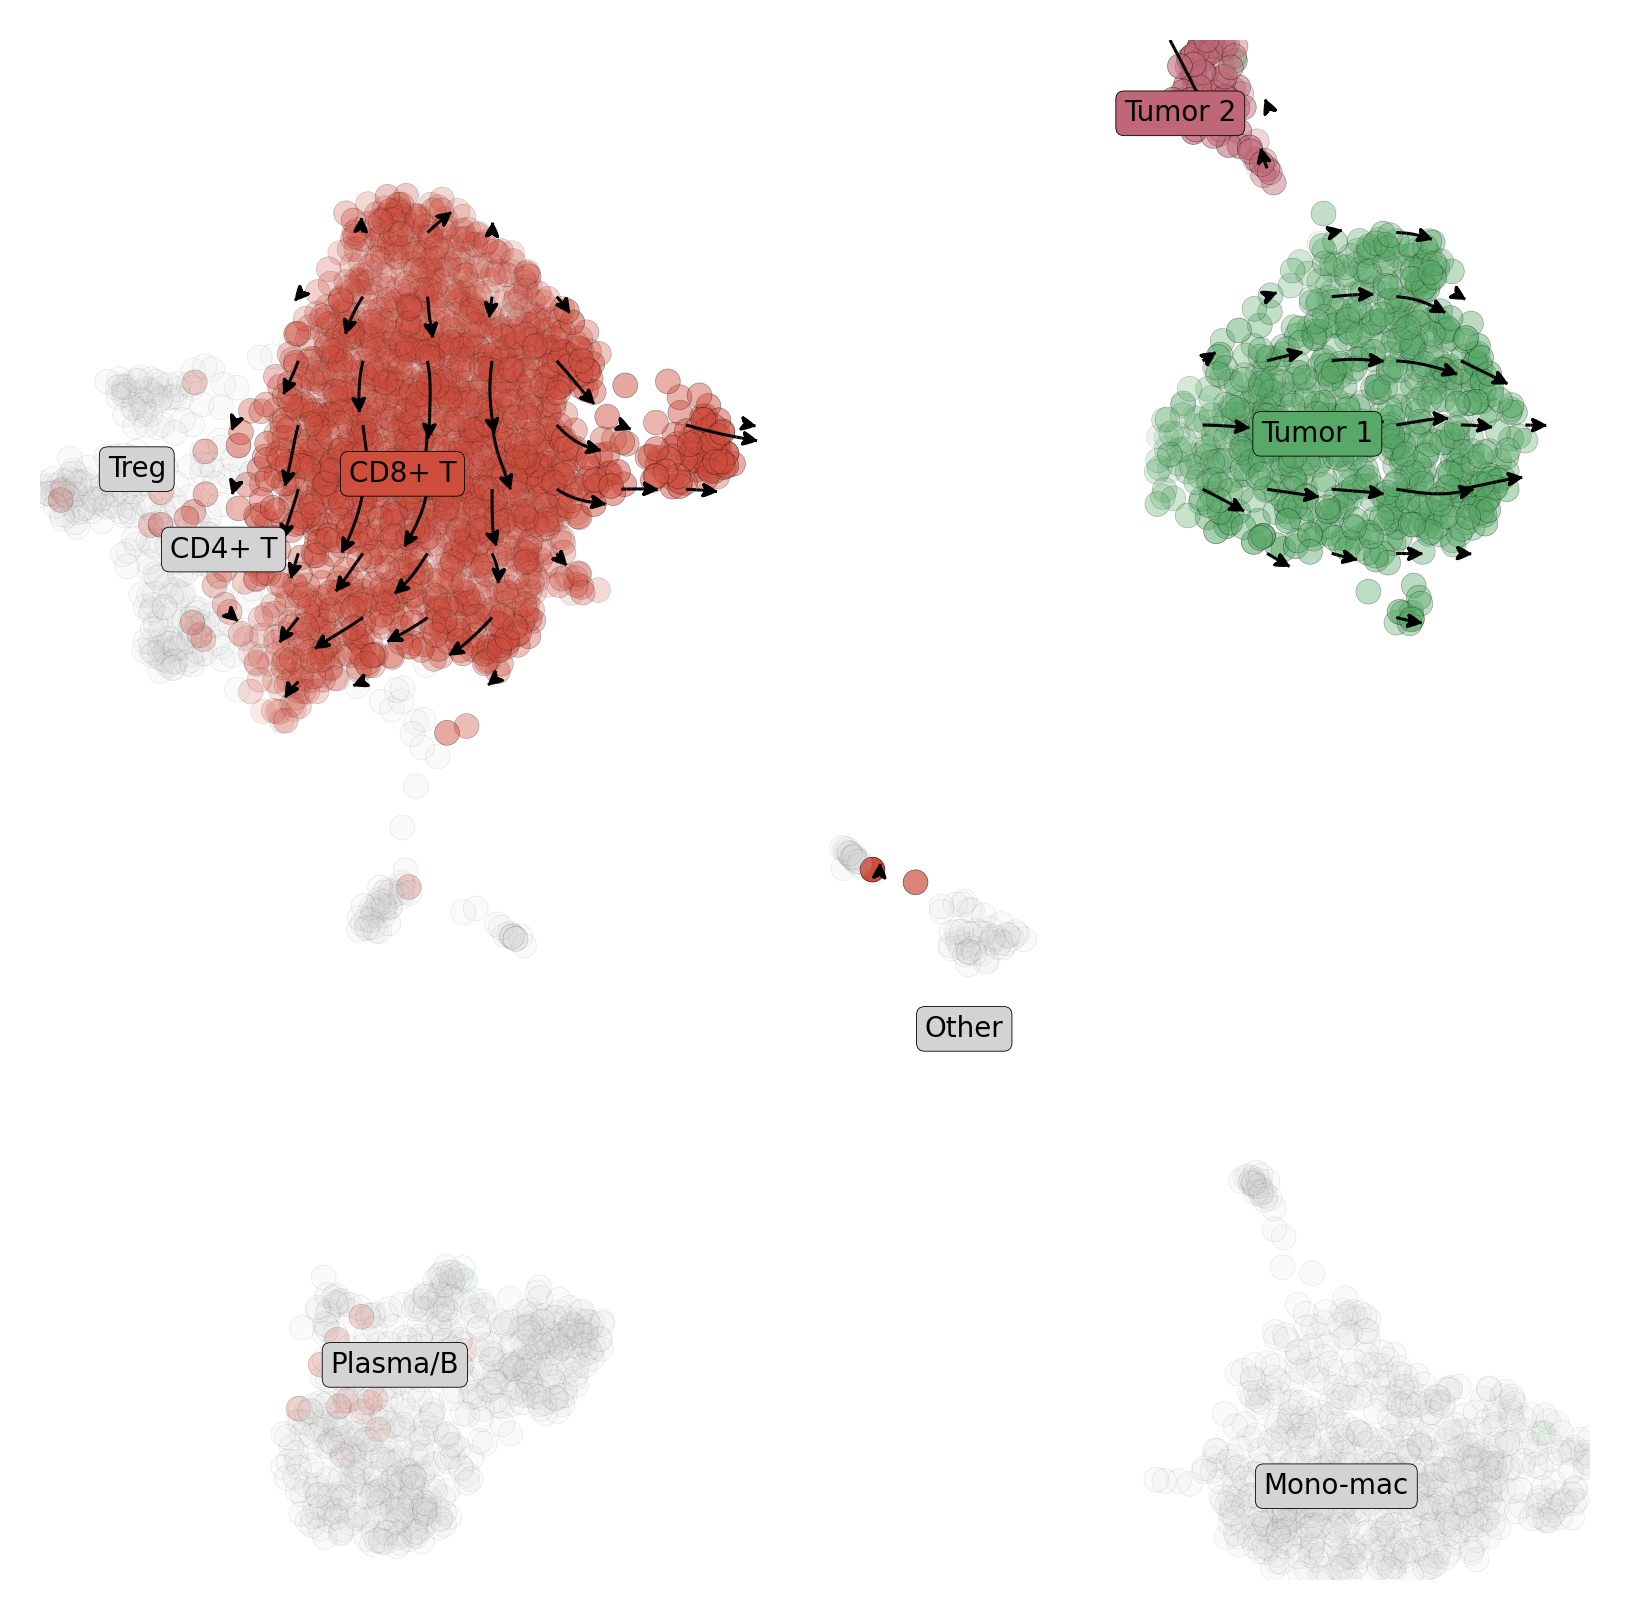

In [27]:
grid_points, vector_field = melanoma.plot_arrows(
    perturb_target='', 
    perturbed_df=perturbed_df,
    mode='0',
    hue='cell_type',
    curve=True,
    vector_scale=0.4, 
    grid_scale=2,
    n_neighbors=200,
    scale=3, 
    alpha=1,
    grains=25,
    figsize=(5, 5),
    dpi=200,
    scatter_size=20,
    legend_fontsize=5,
    limit_clusters=True,
    highlight_clusters=[
        'Tumor 1', 
        'Tumor 2',
        'CD8+ T'
    ]
)

plt.show()